In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import itertools

In [ ]:
load_file_path=os.path.join('/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Baseline Mnist', 'Copy of Baseline Mnist 5*5.csv')
print(load_file_path)

save_folder='/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Baseline Mnist/processed data'

/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Baseline Mnist/Copy of Baseline Mnist 5*5.csv


In [ ]:
# Load the CSV file into a dataframe
dataframe = pd.read_csv(load_file_path)

add flops col

In [ ]:
def preprocess_dataframe(df, flops_dict):
    # Step 1: Modify column names and remove specific columns
    #df.rename(columns={'conv1x1_3x3.1': 'conv1x1_3x3', 'conv1x1_5x5.1': 'conv1x1_5x5'}, inplace=True)
    #df.drop(columns=['conv1x1_3x3.0', 'conv1x1_5x5.0'], inplace=True)

    # Step 2: Add FLOPS columns
    for col, value in flops_dict.items():
        df[col] = value

    return df

# Example usage:
flops_dict = {"branch1.0FLOPS": 2.515, "branch2.0FLOPS": 2.515, "branch3.0FLOPS": 2.515, "totalFLOPS": 17.182}
df = preprocess_dataframe(dataframe, flops_dict)

normalize layer feature attribution in this stack

In [ ]:
def normalize_feature_attribution_final(df):
    """
    Final modification of the normalization of feature attributions for each layer.

    Parameters:
    df (DataFrame): The dataframe containing the feature attributions.

    Returns:
    DataFrame: A modified dataframe with normalized feature attributions for each layer.
    """
    # Columns to be normalized
    layers = ['branch1.0','branch2.0','branch3.0']

    # New sum calculation using specific layers
    df['sum_feature_attr'] = df[layers].sum(axis=1)

    # Normalize each layer by dividing by the new sum of feature attributions
    for layer in layers:
        df[f'norm_{layer}'] = df[layer] / df['sum_feature_attr']

    df.drop(['sum_feature_attr','branch1.0','branch2.0','branch3.0'], axis=1, inplace=True)

    return df

# Example usage of the final modified function
normalized_final_df = normalize_feature_attribution_final(df.copy())

get average and normalzied variance for each combination of hyperparameter

In [ ]:
def calculate_normalized_variance(df, method, flops_dict):
    """
    Modified combined function to calculate the average and normalized variance of each layer's feature attribution
    for a given method, including both average and variance in one dataframe, along with average accuracy after each epoch.
    This version also includes FLOPS information.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    method (str): The method to filter the data ('deeplift' or 'integrated_gradients').
    flops_dict (dict): Dictionary containing FLOPS values for different layers.

    Returns:
    DataFrame: A dataframe with the average and normalized variance for each layer combined, and average accuracy after each epoch, including FLOPS info.
    """
    # Filter the dataframe based on the method
    filtered_df = df[df['method'] == method]

    # Columns for which to calculate average and normalized variance, excluding certain layers
    layers = ['norm_branch1.0','norm_branch2.0','norm_branch3.0']
    accuracy_columns = ['train accuracy epoch0', 'test accuracy epoch0']

    # Group by hyperparameters and calculate mean and variance for feature attributions and accuracy
    grouped = filtered_df.groupby(['initial_lr', 'optimizer', 'criterion', 'train_data_used', 'train_set_shuffle', 'train_batch_size'])
    avg_norm = grouped[layers].mean()
    var_norm = grouped[layers].var()
    avg_acc = grouped[accuracy_columns].mean()

    # Calculate normalized variance (variance/mean)
    norm_var = var_norm / avg_norm

    # Combine average and normalized variance into one dataframe
    combined_df = avg_norm.copy()
    for layer in layers:
        combined_df[f'norm_var_{layer}'] = norm_var[layer]

    # Calculate the average normalized variance across the selected layers
    norm_var_layers = [f'norm_var_{layer}' for layer in layers]
    combined_df['avg_normalized_variance'] = combined_df[norm_var_layers].mean(axis=1)

    # Adding average accuracy columns
    for acc_col in accuracy_columns:
        combined_df[acc_col] = avg_acc[acc_col]

    # Add FLOPS information
    for flops_key, flops_value in flops_dict.items():
        combined_df[flops_key] = flops_value

    return combined_df

# Example usage
combined_avg_norm_var_acc_deeplift = calculate_normalized_variance(normalized_final_df, 'deeplift', flops_dict)

In [ ]:
combined_avg_norm_var_acc_deeplift.to_csv(save_folder+"/Baseline Mnist 5*5 dl.csv")
combined_avg_norm_var_acc_deeplift=pd.read_csv(save_folder+"/Baseline Mnist 5*5 dl.csv")

In [ ]:
def filter_by_accuracy(df, threshold=70.0):
    """
    Function to filter out rows where the average accuracy across epoch 3 (both train and test) is lower than a specified threshold.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    threshold (float): The threshold for average accuracy in epoch 3.

    Returns:
    DataFrame: A filtered dataframe with rows having average epoch 3 accuracy higher than the threshold.
    """
    # Columns representing epoch 3 accuracy
    epoch_2_accuracy_cols = ['test accuracy epoch0']

    # Calculate the average accuracy for epoch 3
    df['final_test_accuracy'] = df[epoch_2_accuracy_cols].mean(axis=1)

    # Filter the dataframe based on the threshold
    filtered_df = df[df['final_test_accuracy'] >= threshold]

    return filtered_df

# Apply the function to the dataframes for 'deeplift' and 'integrated_gradients'
filtered_deeplift = filter_by_accuracy(combined_avg_norm_var_acc_deeplift)

# Display the first few rows of the filtered dataframes
filtered_deeplift

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,norm_branch1.0,norm_branch2.0,norm_branch3.0,norm_var_norm_branch1.0,norm_var_norm_branch2.0,norm_var_norm_branch3.0,avg_normalized_variance,train accuracy epoch0,test accuracy epoch0,branch1.0FLOPS,branch2.0FLOPS,branch3.0FLOPS,totalFLOPS,final_test_accuracy
0,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,0.359266,0.342016,0.298718,0.033361,0.083974,0.066431,0.061255,93.383556,94.777333,2.515,2.515,2.515,17.182,94.777333
1,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,32,0.366410,0.334738,0.298852,0.030286,0.077737,0.059420,0.055814,92.680778,95.220667,2.515,2.515,2.515,17.182,95.220667
2,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,64,0.369172,0.336052,0.294776,0.025140,0.064788,0.057408,0.049112,91.511778,94.700000,2.515,2.515,2.515,17.182,94.700000
3,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.364511,0.337947,0.297542,0.033890,0.080006,0.061439,0.058445,93.429000,96.331333,2.515,2.515,2.515,17.182,96.331333
4,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,32,0.367581,0.337831,0.294588,0.024077,0.070501,0.061673,0.052084,92.962778,96.159333,2.515,2.515,2.515,17.182,96.159333
5,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,0.368612,0.335289,0.296099,0.027166,0.060977,0.057185,0.048443,91.983000,95.974667,2.515,2.515,2.515,17.182,95.974667
6,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,0.365179,0.347651,0.287171,0.052739,0.098476,0.083890,0.078368,92.776222,94.032000,2.515,2.515,2.515,17.182,94.032000
7,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,32,0.374213,0.337794,0.287993,0.035375,0.083184,0.079232,0.065930,92.740000,94.572000,2.515,2.515,2.515,17.182,94.572000
8,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,64,0.359820,0.344852,0.295328,0.042295,0.083081,0.070118,0.065165,92.186222,94.758667,2.515,2.515,2.515,17.182,94.758667
9,0.0007,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,16,0.359960,0.341097,0.298944,0.056349,0.113415,0.107234,0.092333,92.767000,95.686000,2.515,2.515,2.515,17.182,95.686000


# Graph

In [ ]:
def plot_variance_for_multiple_hyperparam_values(df, hyperparam, variables):
    """
    Plots bar graphs of the average variance of each layer and the overall average variance
    for multiple values of a given hyperparameter.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    hyperparam (str): The hyperparameter to vary.
    variables (list): A list of values for the hyperparameter to compare.

    Returns:
    None: The function plots graphs directly.
    """
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = [col for col in df.columns if 'norm_var' in col]
    variance_columns.append('avg_normalized_variance')

    # Preparing data for plotting
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var]
        avg_variances = subset[variance_columns].mean().to_frame().T
        avg_variances['hyperparam_value'] = var
        plot_data = pd.concat([plot_data, avg_variances])

    plot_data.set_index('hyperparam_value', inplace=True)

    # Plotting average variance for each layer and overall average
    plot_data.plot(kind='bar')
    plt.title(f'Average Variance for Different {hyperparam} Values')
    plt.ylabel('Average Variance')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.show()


In [34]:
def plot_ave_for_multiple_hyperparam_values(df, hyperparam, variables):
    """
    Plots bar graphs of the average variance of each layer and the overall average variance
    for multiple values of a given hyperparameter.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    hyperparam (str): The hyperparameter to vary.
    variables (list): A list of values for the hyperparameter to compare.

    Returns:
    None: The function plots graphs directly.
    """
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = [col for col in df.columns if 'norm_branch' in col]

    # Preparing data for plotting
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var]
        avg_variances = subset[variance_columns].mean().to_frame().T
        avg_variances['hyperparam_value'] = var
        plot_data = pd.concat([plot_data, avg_variances])

    plot_data.set_index('hyperparam_value', inplace=True)

    # Plotting average variance for each layer and overall average
    plot_data.plot(kind='bar')
    plt.title(f'Average Variance for Different {hyperparam} Values')
    plt.ylabel('Average Variance')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
filtered_deeplift.to_csv(save_folder+"/Baseline Mnist 5*5 dl ave var.csv")

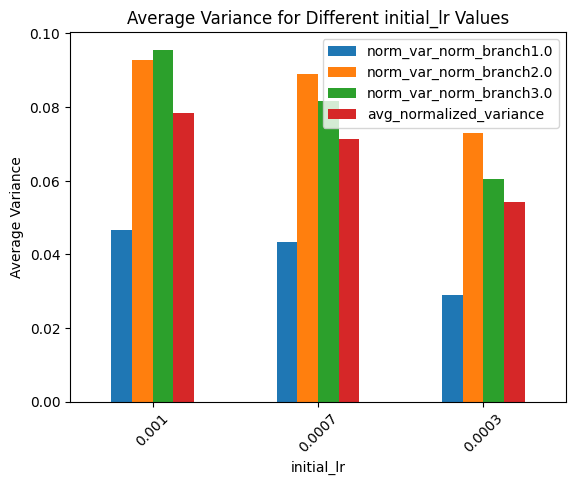

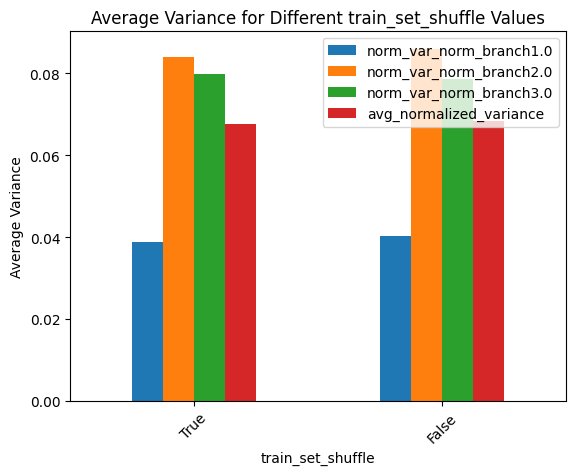

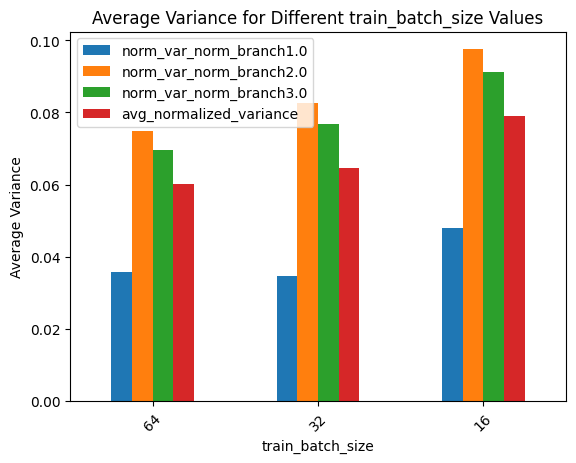

In [ ]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.0007, 0.0003],
    'train_set_shuffle': [True,False],
    'train_batch_size': [64, 32, 16]
}
for hyperparam, variables in hyperparams_choice_list.items():
    plot_variance_for_multiple_hyperparam_values(filtered_deeplift, hyperparam, variables)

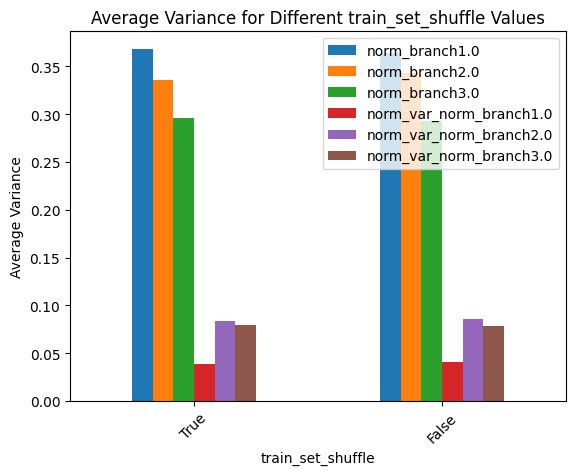

In [38]:
hyperparams_choice_list = {
    'train_set_shuffle': [True,False],
}
for hyperparam, variables in hyperparams_choice_list.items():
    plot_ave_for_multiple_hyperparam_values(filtered_deeplift, hyperparam, variables)

# T test

In [ ]:
def perform_t_test(df, target_column, condition_column, choice1, choice2):
    # Splitting the data into two groups based on the condition
    group1 = df[df[condition_column] == choice1][target_column]
    group2 = df[df[condition_column] == choice2][target_column]

    # Performing the independent t-test
    t_statistic, p_value = ttest_ind(group1, group2)

    return t_statistic, p_value

initial_lr

In [ ]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0007)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 1.053439106023299 P-value: 0.31692788102621894


In [ ]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0003)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 4.728646916073536 P-value: 0.0008058249459344745


In [ ]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'initial_lr', 0.0007, 0.0003)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 3.2233373282069073 P-value: 0.009123388144957409


train_set_shuffle

In [ ]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_set_shuffle', True, False)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -0.11805671949188824 P-value: 0.9074921084998391


train_batch_size

In [ ]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_batch_size', 64, 32)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -0.8367919914262375 P-value: 0.4222558850355954


In [ ]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_batch_size', 64, 16)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -2.565773581961301 P-value: 0.02809359205968979


In [ ]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_batch_size', 32, 16)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -1.8526343505321514 P-value: 0.09363977332813994


# Paired T test

In [ ]:
def one_sided_paired_ttest(data_set1, data_set2):
    """
    Perform a one-sided paired t-test to determine if the first data set is statistically larger than the second.

    Parameters:
    data_set1 (array-like): The first set of data.
    data_set2 (array-like): The second set of data.

    Returns:
    tuple: A tuple containing the t-statistic and the one-sided p-value.
    """
    t_statistic, p_value = ttest_rel(data_set1, data_set2)

    # Adjust p-value for one-sided test
    if t_statistic > 0:
        p_value_one_sided = p_value / 2
    else:
        p_value_one_sided = 1 - (p_value / 2)

    return t_statistic, p_value_one_sided

# Example usage:
# t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
# print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)


In [ ]:
def find_rows_with_fixed_conditions(df, conditions):
    # Filter the DataFrame based on the conditions
    filtered_df = df
    for column, value in conditions.items():
        filtered_df = filtered_df[filtered_df[column] == value]

    return filtered_df

In [ ]:
def generate_hyperparameter_combinations(hyperparams):
    """
    Generate a sequence of hyperparameter combinations.

    :param hyperparams: A dictionary where keys are the names of hyperparameters,
                        and values are lists of possible choices for each hyperparameter.
    :return: A list of dictionaries, each representing a unique combination of hyperparameters.
    """
    # Extract the hyperparameter names and their corresponding choices
    keys, values = zip(*hyperparams.items())

    # Generate all possible combinations of hyperparameter values
    all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    return all_combinations

In [ ]:
def get_all_pairs(df, hyperparams_choice_list, target_column, condition_column, choice1, choice2):
    hyperparams_choice_list_compressed = {key: value for key, value in hyperparams_choice_list.items() if key != condition_column}
    all_combinations = generate_hyperparameter_combinations(hyperparams_choice_list_compressed)
    choice1_target_values=[]
    choice2_target_values=[]
    for conditions in all_combinations:
      x = find_rows_with_fixed_conditions(df, conditions)
      try:
        choice1_value = float(x[x[condition_column] == choice1][target_column])
        choice2_value = float(x[x[condition_column] == choice2][target_column])
        print(choice1_value, choice2_value)
      except:
        continue
      choice1_target_values.append(choice1_value)
      choice2_target_values.append(choice2_value)
    return choice1_target_values, choice2_target_values

initial_lr

In [ ]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0007)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0659840858055997 0.0639850798090785
0.073695720571563 0.0616585316773977
0.0909916816838324 0.0923325844172756
0.0676853301414494 0.0651648568439238
0.0790935656908191 0.0659303726282974
0.0924184966356173 0.0783684375628127
T-statistic: 2.566919007909415 One-sided P-value: 0.025111392953316797


In [ ]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.0007, 0.0003)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0639850798090785 0.0484425278612309
0.0616585316773977 0.0520836099081346
0.0923325844172756 0.0584452907398188
0.0651648568439238 0.0491119926210828
0.0659303726282974 0.0558141407602747
0.0783684375628127 0.0612551883995958
T-statistic: 4.723870744105725 One-sided P-value: 0.002612281563383782


In [ ]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.001, 0.0003)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0659840858055997 0.0484425278612309
0.073695720571563 0.0520836099081346
0.0909916816838324 0.0584452907398188
0.0676853301414494 0.0491119926210828
0.0790935656908191 0.0558141407602747
0.0924184966356173 0.0612551883995958
T-statistic: 9.303096707868159 One-sided P-value: 0.00012073161148374132


train_set_shuffle

In [ ]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_set_shuffle', True, False)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0659840858055997 0.0676853301414494
0.073695720571563 0.0790935656908191
0.0909916816838324 0.0924184966356173
0.0639850798090785 0.0651648568439238
0.0616585316773977 0.0659303726282974
0.0923325844172756 0.0783684375628127
0.0484425278612309 0.0491119926210828
0.0520836099081346 0.0558141407602747
0.0584452907398188 0.0612551883995958
T-statistic: -0.4182124996089918 One-sided P-value: 0.6566038739396258


train_batch_size

In [ ]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 32, 64)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.073695720571563 0.0659840858055997
0.0790935656908191 0.0676853301414494
0.0616585316773977 0.0639850798090785
0.0659303726282974 0.0651648568439238
0.0520836099081346 0.0484425278612309
0.0558141407602747 0.0491119926210828
T-statistic: 2.287011528322105 One-sided P-value: 0.03545685067932567


In [ ]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 16, 32)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0909916816838324 0.073695720571563
0.0924184966356173 0.0790935656908191
0.0923325844172756 0.0616585316773977
0.0783684375628127 0.0659303726282974
0.0584452907398188 0.0520836099081346
0.0612551883995958 0.0558141407602747
T-statistic: 3.7965779063424026 One-sided P-value: 0.006336388567558064


In [ ]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 16, 64)
t_statistic, p_value_one_sided = one_sided_paired_ttest(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "One-sided P-value:", p_value_one_sided)

0.0909916816838324 0.0659840858055997
0.0924184966356173 0.0676853301414494
0.0923325844172756 0.0639850798090785
0.0783684375628127 0.0651648568439238
0.0584452907398188 0.0484425278612309
0.0612551883995958 0.0491119926210828
T-statistic: 5.808411743467919 One-sided P-value: 0.0010668204964432951


#layer feature attribution rank frequency comparison

In [ ]:
normalized_df = normalized_final_df[normalized_final_df['method'] == 'deeplift']
normalized_df_highacc = filter_by_accuracy(normalized_df)
normalized_df_highacc

<ipython-input-9-78e4492ffc89>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['final_test_accuracy'] = df[epoch_2_accuracy_cols].mean(axis=1)


,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,branch1.1,branch2.1,branch3.1,train accuracy epoch0,...,method,run,branch1.0FLOPS,branch2.0FLOPS,branch3.0FLOPS,totalFLOPS,norm_branch1.0,norm_branch2.0,norm_branch3.0,final_test_accuracy
0,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,430.35153,175.872760,163.07054,91.956667,...,deeplift,0,2.515,2.515,2.515,17.182,0.559411,0.228615,0.211974,95.32
2,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,223.10062,228.238660,252.99908,93.383333,...,deeplift,1,2.515,2.515,2.515,17.182,0.316752,0.324047,0.359201,95.47
4,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,170.69978,442.226260,99.39165,92.821667,...,deeplift,2,2.515,2.515,2.515,17.182,0.239640,0.620827,0.139533,96.53
6,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,205.18367,558.006040,88.63321,92.226667,...,deeplift,3,2.515,2.515,2.515,17.182,0.240876,0.655073,0.104051,96.37
8,0.0010,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,True,64,372.84995,54.757137,436.09906,92.398333,...,deeplift,4,2.515,2.515,2.515,17.182,0.431686,0.063398,0.504916,96.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,403.22794,258.037400,477.42830,93.388333,...,deeplift,10,2.515,2.515,2.515,17.182,0.354115,0.226608,0.419277,94.22
532,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,358.62054,351.170800,375.26883,93.128333,...,deeplift,11,2.515,2.515,2.515,17.182,0.330508,0.323642,0.345851,93.52
534,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,364.00958,183.354450,449.92166,93.538333,...,deeplift,12,2.515,2.515,2.515,17.182,0.365000,0.183854,0.451146,94.97
536,0.0003,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1,False,16,597.69360,509.528720,345.59332,93.615000,...,deeplift,13,2.515,2.515,2.515,17.182,0.411404,0.350718,0.237878,95.69


In [ ]:
# Select the columns of interest
cols_of_interest = ['norm_branch1.0', 'norm_branch2.0', 'norm_branch3.0']
data_subset = normalized_df_highacc[cols_of_interest]

# Function to get rank as a string
def get_rank_string(row):
    return ''.join(row.rank().astype(int).astype(str))

# Apply the function to each row
data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)

# Count the frequency of each rank combination
rank_combination_counts = data_subset['rank_combination'].value_counts()

rank_combination_counts

<ipython-input-33-85bc6b39743e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['rank_combination'] = data_subset.apply(get_rank_string, axis=1)


321    82
213    63
231    58
123    31
312    31
132     5
Name: rank_combination, dtype: int64